## 데이터 로드 및 전처리

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# --- PyTorch 라이브러리 ---
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 시각화 스타일 설정 ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- 데이터 로딩 ---
try:
    train_df = pd.read_csv('train_aWnotuB.csv')
    test_df = pd.read_csv('test_BdBKkAj.csv')
except FileNotFoundError:
    print("오류: train_aWnotuB.csv 또는 test_BdBKkAj.csv 파일을 찾을 수 없습니다.")
    train_df, test_df = pd.DataFrame(), pd.DataFrame()

print("Train Data Sample:")
display(train_df.head())
print("\nTest Data Sample:")
display(test_df.head())

Train Data Sample:


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041



Test Data Sample:


,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [17]:
def preprocess(df):
    """DateTime 변환 및 기본 정보 출력 함수"""
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

print("--- Train Data Info ---")
train_df.info()

print("\n--- Data Count per Junction ---")
print(train_df['Junction'].value_counts())

--- Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB

--- Data Count per Junction ---
Junction
1    14592
2    14592
3    14592
4     4344
Name: count, dtype: int64


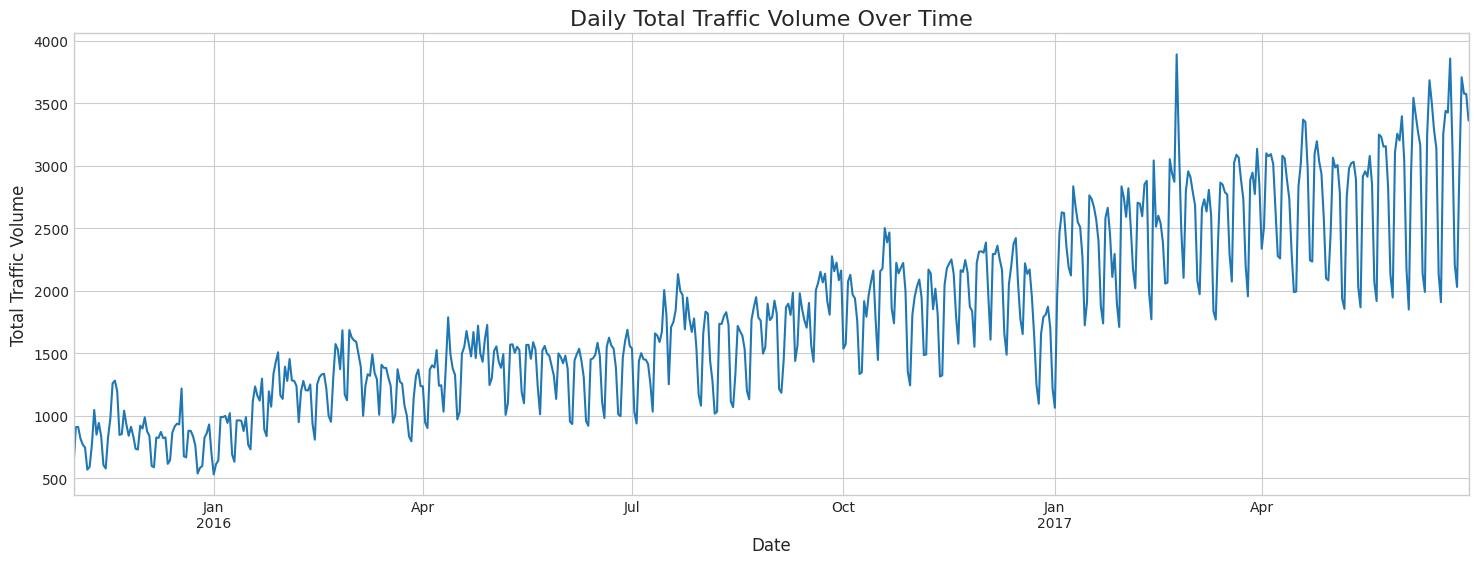

In [18]:
plt.figure(figsize=(18, 6))
# 데이터가 너무 많으므로 일별 평균으로 리샘플링하여 시각화
daily_traffic = train_df.set_index('DateTime').resample('D')['Vehicles'].sum()
daily_traffic.plot()
plt.title('Daily Total Traffic Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Traffic Volume', fontsize=12)
plt.show()

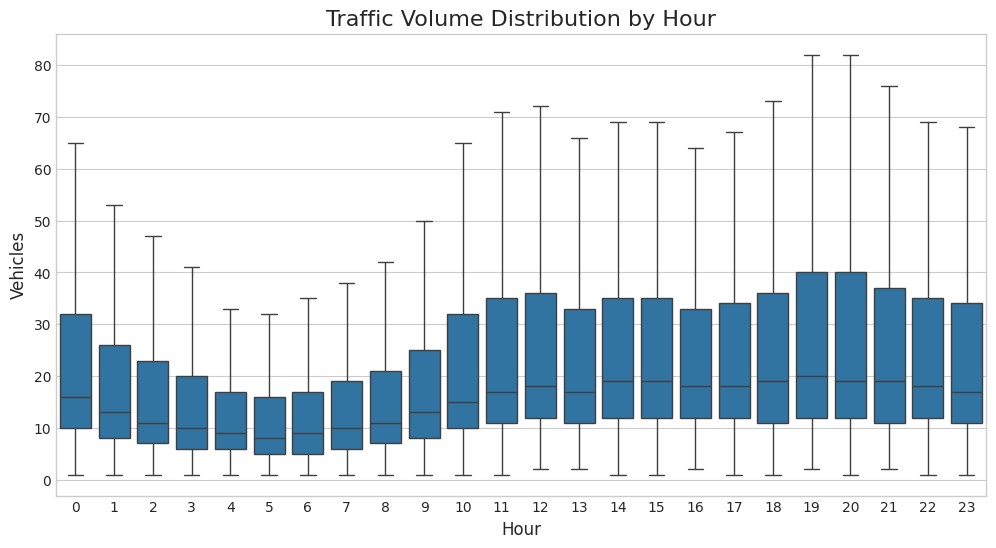

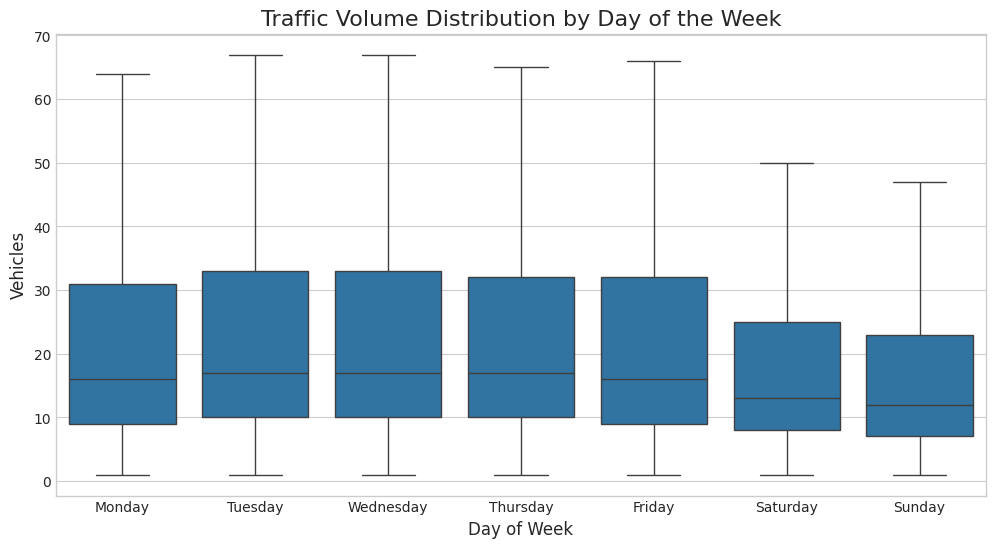

In [19]:
# 시간 관련 피처 생성
train_df['Hour'] = train_df['DateTime'].dt.hour
train_df['DayOfWeek'] = train_df['DateTime'].dt.day_name()

# 1. 시간대별 교통량 패턴
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Vehicles', data=train_df, showfliers=False)
plt.title('Traffic Volume Distribution by Hour', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Vehicles', fontsize=12)
plt.show()

# 2. 요일별 교통량 패턴
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(12, 6))
sns.boxplot(x='DayOfWeek', y='Vehicles', data=train_df, order=day_order, showfliers=False)
plt.title('Traffic Volume Distribution by Day of the Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Vehicles', fontsize=12)
plt.show()

##  모델링을 위한 데이터 준비

In [20]:
# --- 3.1. 데이터 필터링 및 정규화 ---
junction = 1
junction_df = train_df[train_df['Junction'] == junction].copy()
junction_df.set_index('DateTime', inplace=True)
traffic_data = junction_df['Vehicles'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_traffic = scaler.fit_transform(traffic_data)

In [21]:
# --- 3.2. 시계열 데이터셋 구성 (3D 출력으로 수정) ---
def create_dataset(dataset, time_steps=1):
    """3차원 시계열 데이터셋(샘플, 시퀀스, 피처)을 생성하는 함수"""
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        # 마지막 차원(피처)을 유지하도록 슬라이싱 수정
        a = dataset[i:(i + time_steps), :] 
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

In [22]:
TIME_STEPS = 24
train_size = int(len(scaled_traffic) * 0.8)
train_data, val_data = scaled_traffic[0:train_size,:], scaled_traffic[train_size:len(scaled_traffic),:]

X_train_np, y_train_np = create_dataset(train_data, TIME_STEPS)
X_val_np, y_val_np = create_dataset(val_data, TIME_STEPS)

# [디버깅] 생성된 NumPy 배열의 형태 확인 (이 단계에서 3D여야 함)
print(f"Shape of NumPy array X_train_np: {X_train_np.shape}")
print(f"Shape of NumPy array X_val_np: {X_val_np.shape}")


# --- 3.3. PyTorch 텐서로 변환 및 DataLoader 생성 ---
# X_train과 X_val은 이미 3D이므로 불필요한 차원 추가 코드는 모두 제거합니다.
X_train = torch.from_numpy(X_train_np).float()
y_train = torch.from_numpy(y_train_np).float().view(-1, 1)
X_val = torch.from_numpy(X_val_np).float()
y_val = torch.from_numpy(y_val_np).float().view(-1, 1)

print(f"\nShape of PyTorch tensor X_train: {X_train.shape}")
print(f"Shape of PyTorch tensor X_val: {X_val.shape}")


Shape of NumPy array X_train_np: (11649, 24, 1)
Shape of NumPy array X_val_np: (2895, 24, 1)

Shape of PyTorch tensor X_train: torch.Size([11649, 24, 1])
Shape of PyTorch tensor X_val: torch.Size([2895, 24, 1])


In [23]:
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 모델링

In [24]:
# --- 4.1. 모델 클래스 정의 ---
class TrafficLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout_prob=0.2):
        super(TrafficLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x는 [batch_size, sequence_length, input_size] 형태의 3D 텐서
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        out = self.dropout(last_time_step_out)
        out = self.fc(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# --- 4.2. 모델 학습 루프 ---
NUM_EPOCHS = 50
model_path = f'best_model_junction_{junction}.pth'
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses, val_losses = [], []

print("\n--- Starting Model Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # [디버깅] 학습 루프 안에서 데이터 배치의 형태 확인
        if i == 0 and epoch == 0:
            print(f"Shape of a batch input to the model: {inputs.shape}")
            
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f'Validation loss improved. Model saved to {model_path}')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


--- Starting Model Training ---
Shape of a batch input to the model: torch.Size([64, 24, 1])
Epoch [1/50], Train Loss: 0.0171, Val Loss: 0.0128
Validation loss improved. Model saved to best_model_junction_1.pth
Epoch [2/50], Train Loss: 0.0048, Val Loss: 0.0052
Validation loss improved. Model saved to best_model_junction_1.pth
Epoch [3/50], Train Loss: 0.0034, Val Loss: 0.0038
Validation loss improved. Model saved to best_model_junction_1.pth
Epoch [4/50], Train Loss: 0.0029, Val Loss: 0.0037
Validation loss improved. Model saved to best_model_junction_1.pth
Epoch [5/50], Train Loss: 0.0024, Val Loss: 0.0026
Validation loss improved. Model saved to best_model_junction_1.pth
Epoch [6/50], Train Loss: 0.0023, Val Loss: 0.0024
Validation loss improved. Model saved to best_model_junction_1.pth
Epoch [7/50], Train Loss: 0.0021, Val Loss: 0.0023
Validation loss improved. Model saved to best_model_junction_1.pth
Epoch [8/50], Train Loss: 0.0020, Val Loss: 0.0024
Epoch [9/50], Train Loss: 0.0

## 모델 성능 검증 및 결과 분석

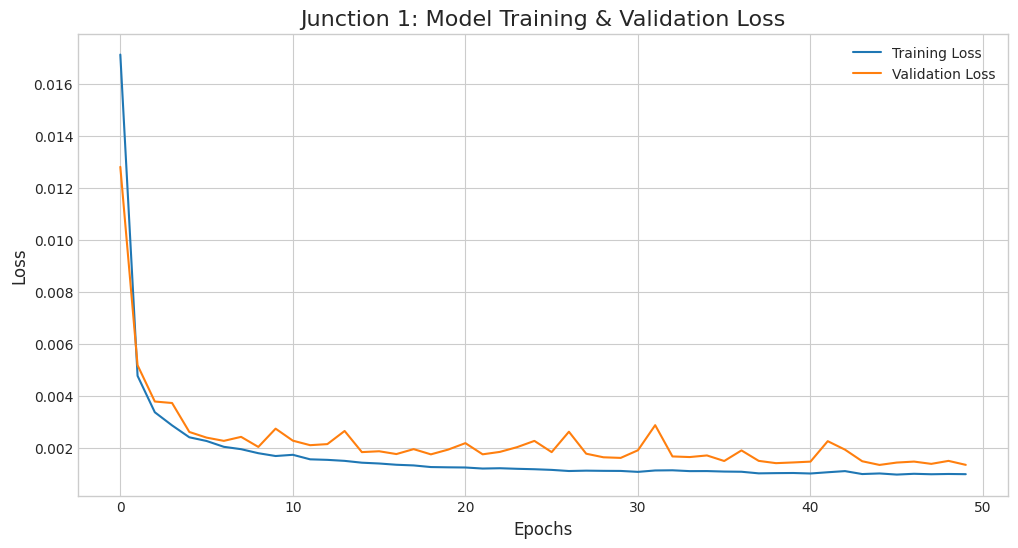

In [26]:
# --- 5.1. 학습 손실 시각화 ---
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Junction {junction}: Model Training & Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

In [27]:
# --- 5.2. 예측 및 성능 평가 ---
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    val_predictions = model(X_val.to(device)).cpu().numpy()

val_predictions_inv = scaler.inverse_transform(val_predictions)
y_val_inv = scaler.inverse_transform(y_val.numpy())

rmse = np.sqrt(mean_squared_error(y_val_inv, val_predictions_inv))
mae = mean_absolute_error(y_val_inv, val_predictions_inv)

print(f"\n--- Junction {junction} Model Validation Performance ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")


--- Junction 1 Model Validation Performance ---
RMSE (Root Mean Squared Error): 5.57
MAE (Mean Absolute Error): 4.16


/tmp/ipykernel_311649/3162376093.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


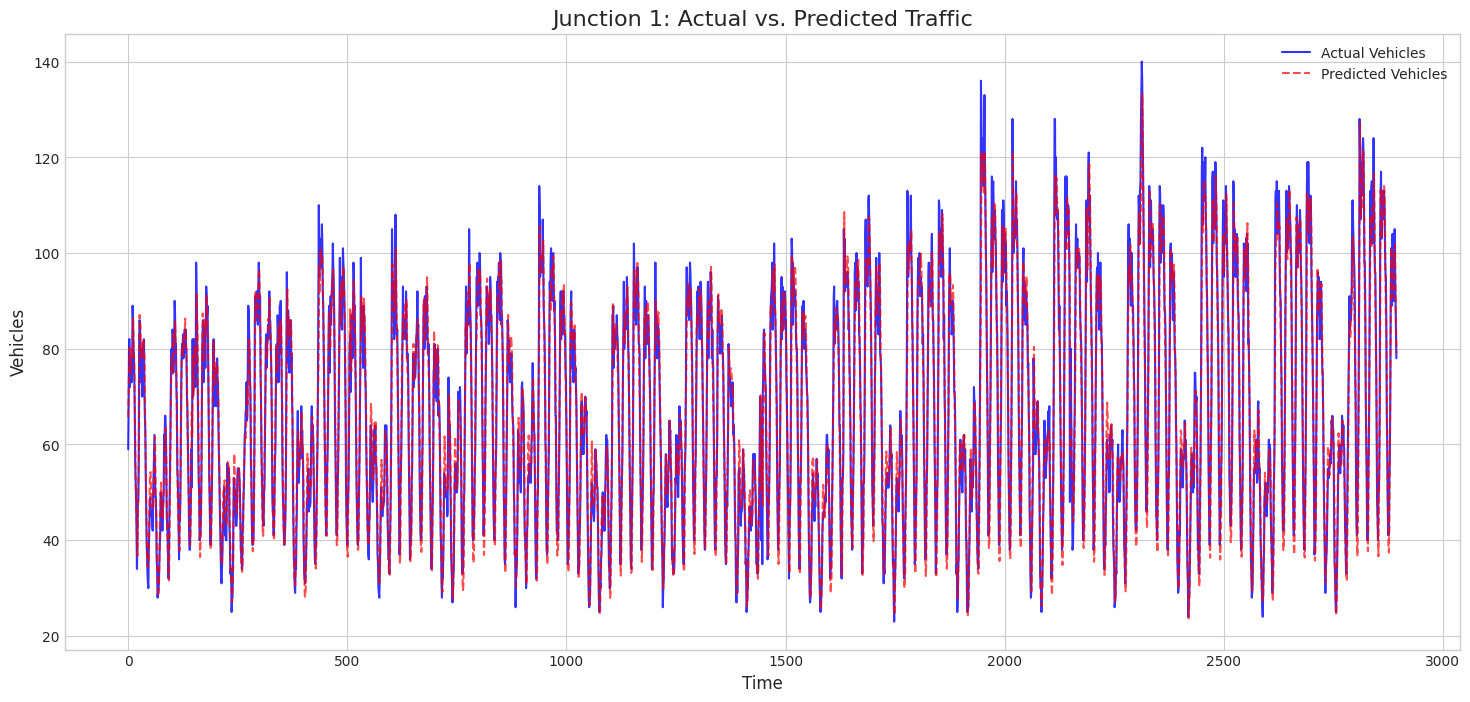

In [28]:
# --- 5.3. 실제값 vs 예측값 시각화 ---
plt.figure(figsize=(18, 8))
plt.plot(y_val_inv, label='Actual Vehicles', color='blue', alpha=0.8)
plt.plot(val_predictions_inv, label='Predicted Vehicles', color='red', linestyle='--', alpha=0.7)
plt.title(f'Junction {junction}: Actual vs. Predicted Traffic', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Vehicles', fontsize=12)
plt.legend()
plt.show()